In [1]:
#%%
import json
import sys
from argparse import Namespace
from pathlib import Path
from time import time

import numpy as np
import torch
import resnet3d

# sys.path.append("resnet3d/")
import torchvision
from IPython.display import HTML
from resnet3d.main import generate_model, get_inference_utils, resume_model
from resnet3d.model import generate_model, make_data_parallel
from torch.backends import cudnn
from torchvision.transforms import transforms
from torchvision.transforms.transforms import Normalize, ToPILImage

sys.path.append("src/")

from utils.dataset_utils import load_jpg_ucf101
from utils.sensitivity_analysis import OcclusionSensitivityMap3D as OSM
from utils.visualization import visualize

In [2]:
#%%
opt_path = "data/r3d_models/finetuning/ucf101/r3d50_K_fc/opts.json"
with open(opt_path, "r") as f:
    model_opt = json.load(f)
model_opt = Namespace(**model_opt)

model_opt.device = torch.device("cpu" if model_opt.no_cuda else "cuda")
if not model_opt.no_cuda:
    cudnn.benchmark = True
if model_opt.accimage:
    torchvision.set_image_backend("accimage")

model_opt.ngpus_per_node = torch.cuda.device_count()

model = generate_model(model_opt)
model = resume_model(model_opt.resume_path, model_opt.arch, model)
model = make_data_parallel(model, model_opt.distributed, model_opt.device)
model.eval()

model_opt.inference_batch_size = 1
for attribute in dir(model_opt):
    if "path" in str(attribute) and getattr(model_opt, str(attribute)) != None:
        setattr(model_opt, str(attribute), Path(getattr(model_opt, str(attribute))))
inference_loader, inference_class_names = get_inference_utils(model_opt)
print(inference_class_names)
class_labels_map = {v.lower(): k for k, v in inference_class_names.items()}



loading checkpoint data/r3d_models/finetuning/ucf101/r3d50_K_fc/save_200.pth model
model: ResNet(
  (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [3]:
#%%
inputs, targets = iter(inference_loader).__next__()
video_size = inputs[[0]].shape
transform = inference_loader.dataset.spatial_transform

_transforms = transform.transforms
idx = [type(i) for i in _transforms].index(resnet3d.spatial_transforms.Normalize)
normalize = _transforms[idx]
mean = torch.tensor(normalize.mean)
std = torch.tensor(normalize.std)

unnormalize = transforms.Compose(
    [
        Normalize((-mean / std).tolist(), (1 / std).tolist()),
        ToPILImage(),
    ]
)



In [4]:
#%%
spatial_crop_size = 16
spatial_stride = 8
temporal_stride = 2

aosa_single = OSM(
    net=model,
    video_size=video_size,
    device=model_opt.device,
    spatial_crop_size=spatial_crop_size,
    spatial_stride=spatial_stride,
    temporal_stride=temporal_stride,
    transform=transform,
    batchsize=400,
    N_stack_mask=1,
)

aosa = OSM(
    net=model,
    video_size=video_size,
    device=model_opt.device,
    spatial_crop_size=spatial_crop_size,
    spatial_stride=spatial_stride,
    temporal_stride=temporal_stride,
    transform=transform,
    batchsize=400,
    N_stack_mask=3,
)




In [5]:
#%%
l = 21
g = 1  # > 0
c = 1  # > 0
n = 1

video = load_jpg_ucf101(l, g, c, n, inference_class_names, transform).transpose(0, 1)
target = l
with torch.inference_mode():
    pred = model(video.unsqueeze(0)).cpu().numpy().argmax()
video_orgimg = []

for i in range(video_size[2]):
    img = video.squeeze().transpose(0, 1)[i]
    video_orgimg.append(np.array(unnormalize(img)))
video_orgimg = np.array(video_orgimg)
print(f'img size: {img.shape}')

start = time()
aosa_single_map = aosa_single.run(video, target)
print(time() - start)

start = time()
aosa_map = aosa.run(video, target)
print(time() - start)

print("heatmap size: ", aosa_single_map.shape)

title = "{} (pred: {})".format(inference_class_names[l], inference_class_names[pred])

s = visualize(
    [aosa_single_map, aosa_map],
    video_orgimg,
    title=title,
)

HTML(s)


img size: torch.Size([3, 112, 112])
masks shape: torch.Size([168, 3, 16, 112, 112])
X shape: torch.Size([168])
org_val shape: torch.Size([])
mask shape in normalize: torch.Size([168, 3, 16, 112, 112])
video_size: torch.Size([1, 3, 16, 112, 112])
map shape: torch.Size([16, 112, 112])
2.8634440898895264
masks shape: torch.Size([168, 3, 16, 112, 112])
X shape: torch.Size([168])
org_val shape: torch.Size([])
mask shape in normalize: torch.Size([168, 3, 16, 112, 112])
video_size: torch.Size([1, 3, 16, 112, 112])
map shape: torch.Size([16, 112, 112])
1.2568426132202148
heatmap size:  (16, 112, 112)
video maps list elements type: <class 'numpy.ndarray'>
video maps shape: (16, 112, 112)


masks shape: torch.Size([168, 3, 16, 112, 112])
(168, 3, 16, 112, 112)
<class 'numpy.ndarray'>


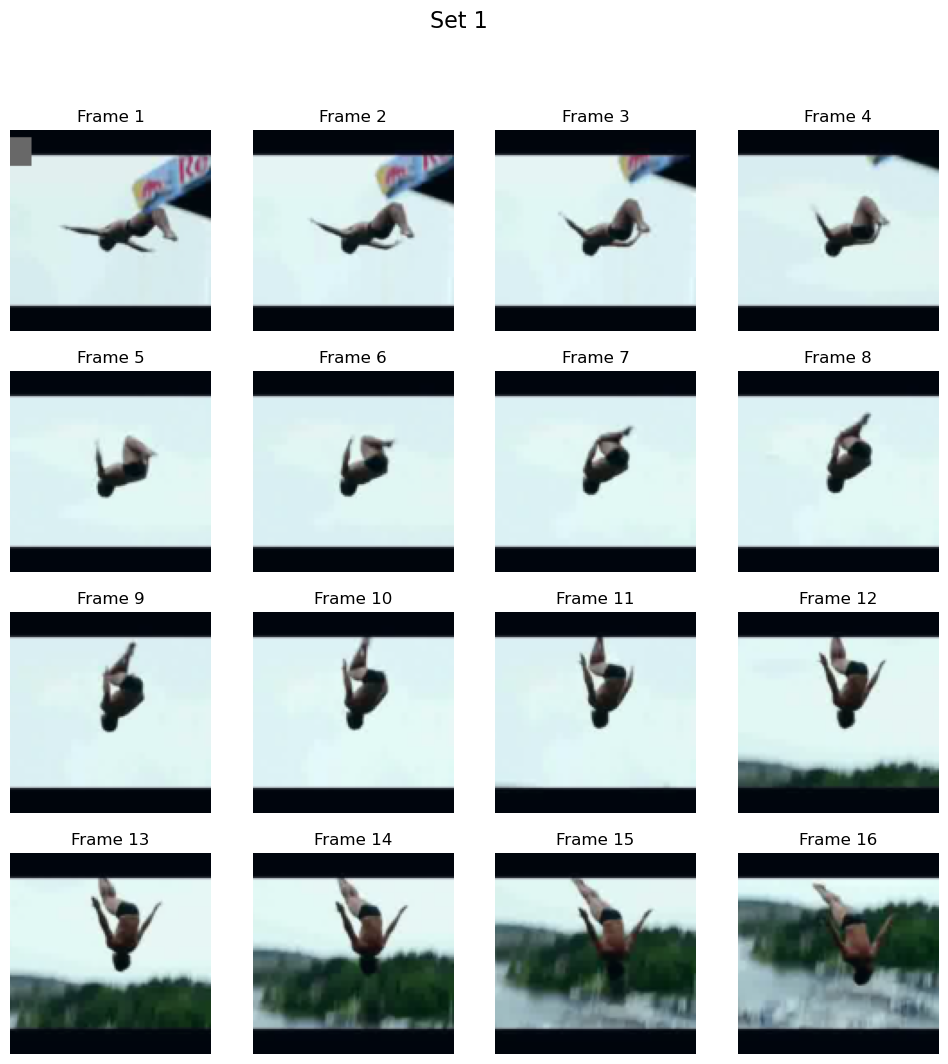

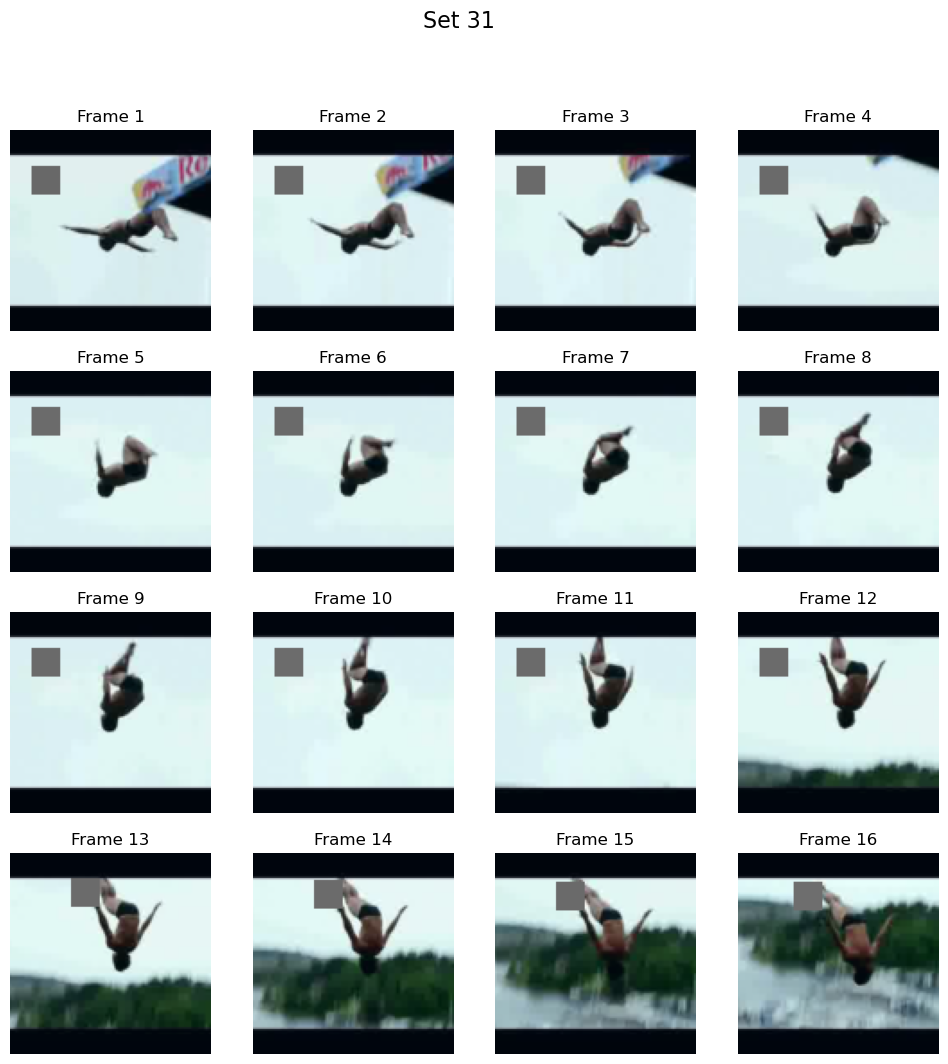

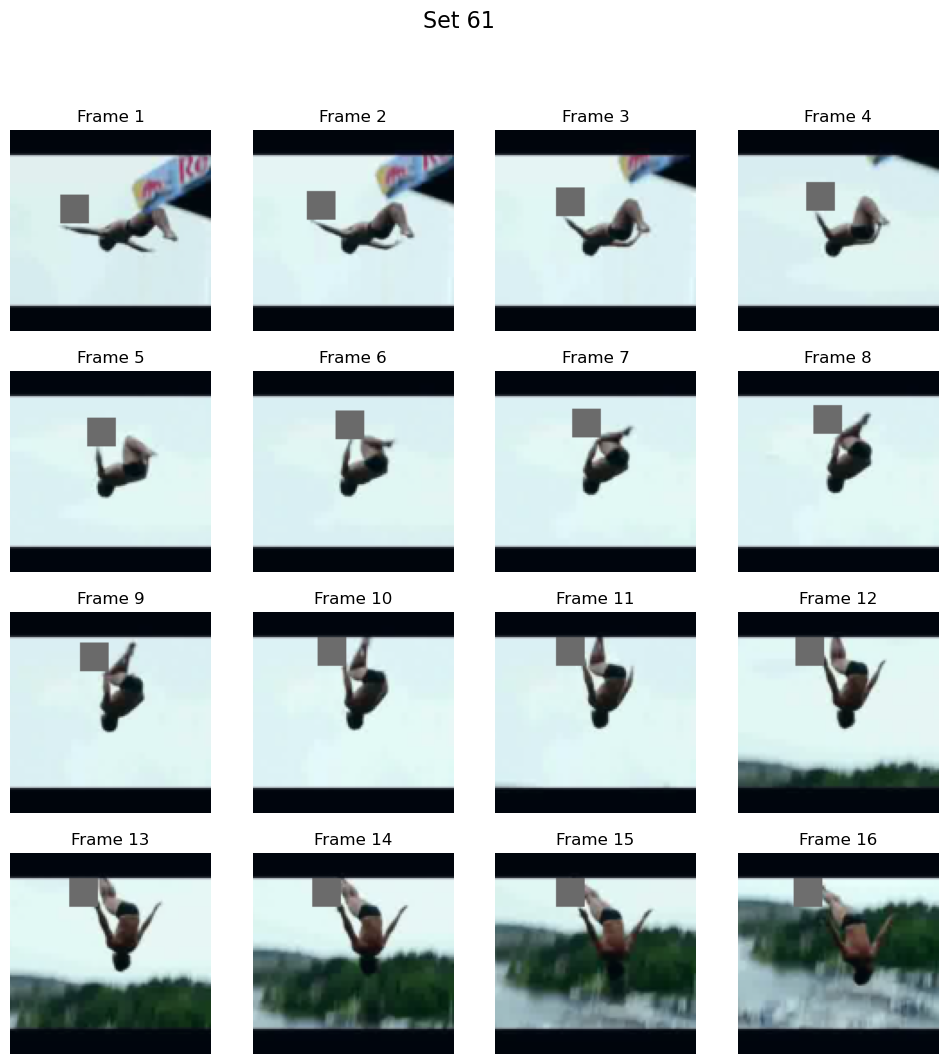

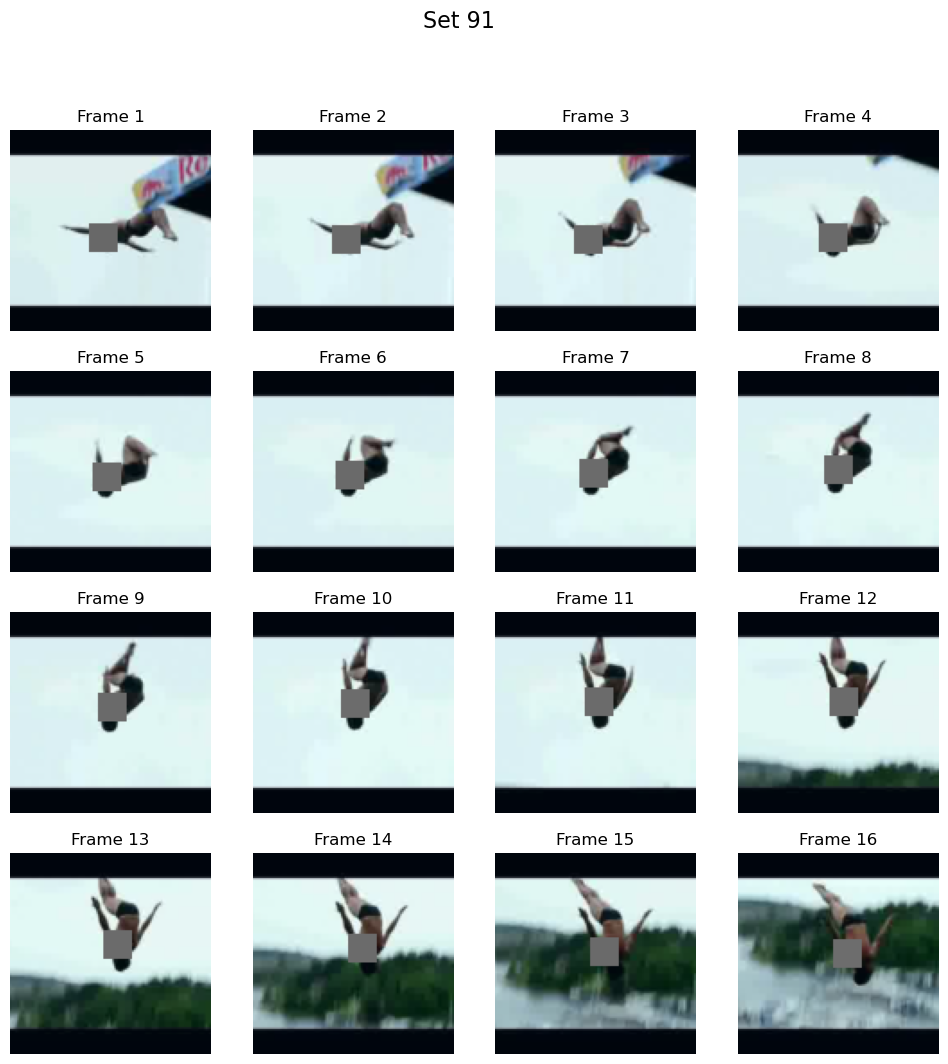

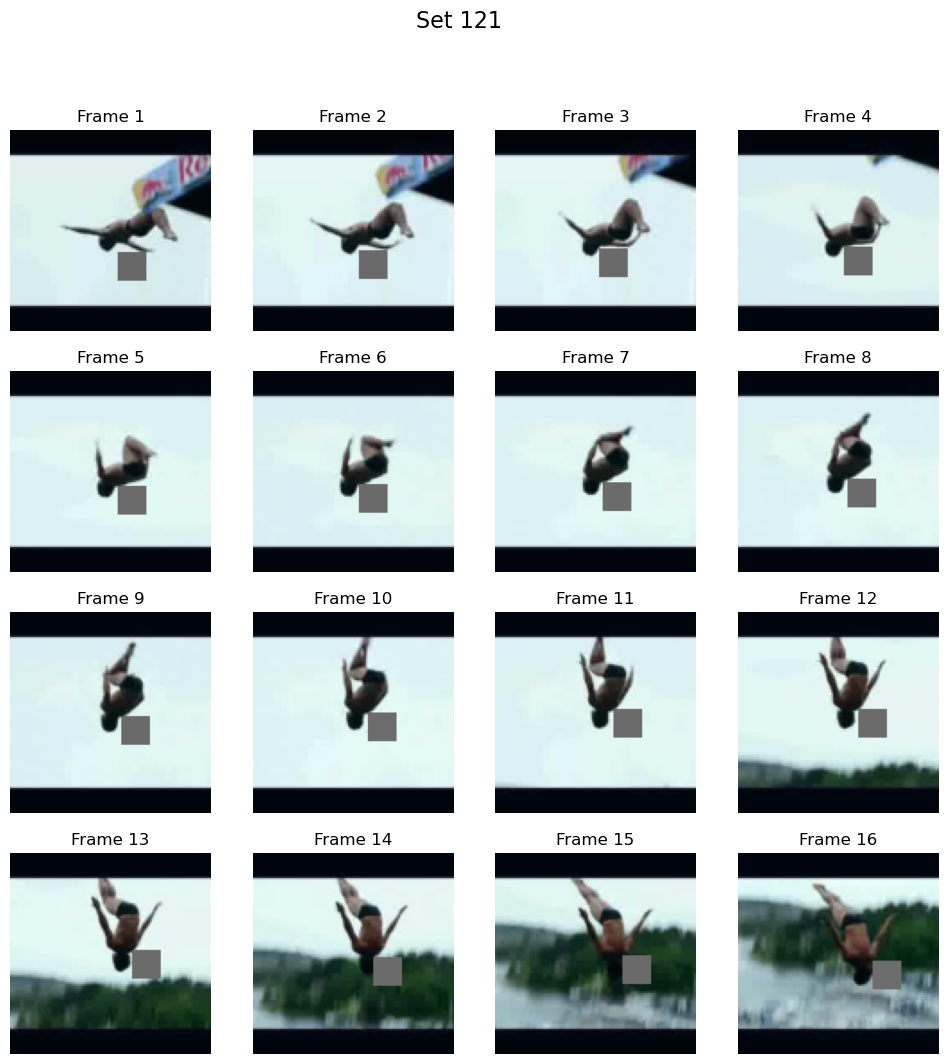

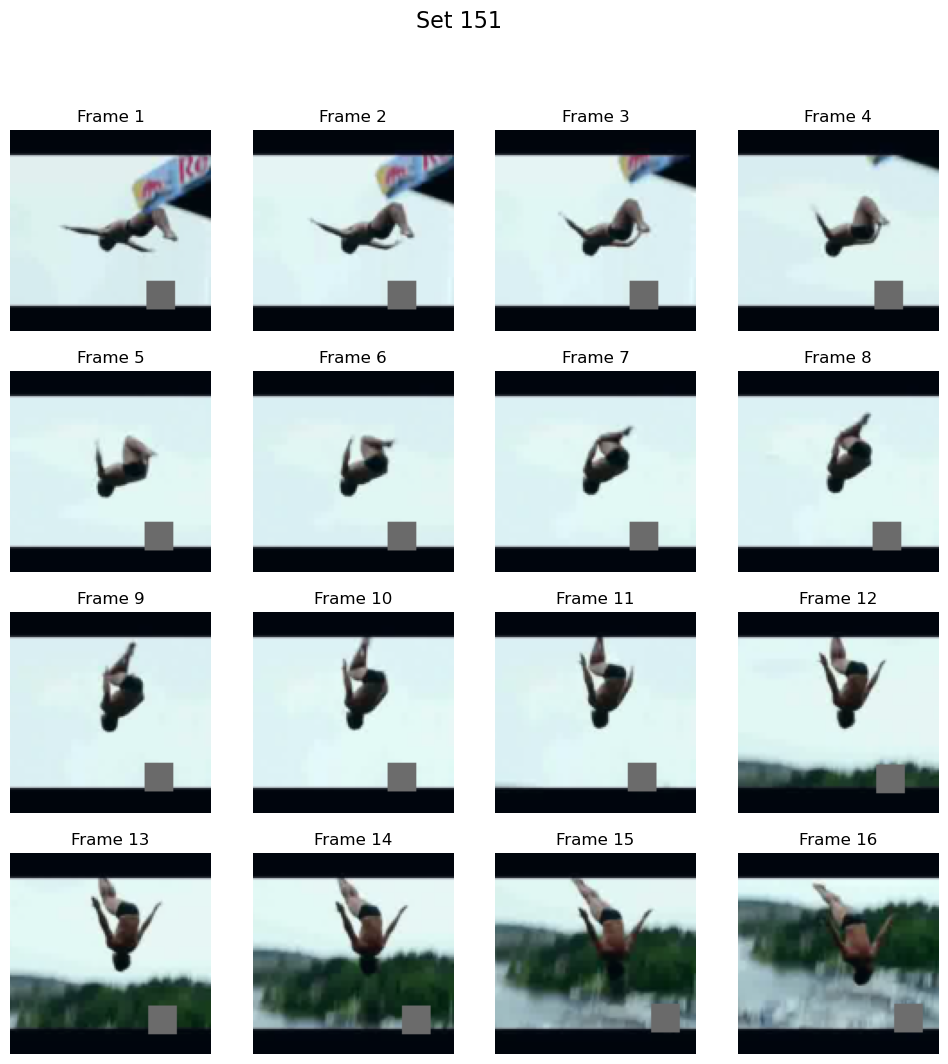

In [10]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

img_with_mask = aosa_single.apply_masks_to_video(video, target).numpy() # 動画に168通りのマスクの付け方をしている．(AOSA済み)
print(img_with_mask.shape)
print(type(img_with_mask))

output_dir = './masks'
os.makedirs(output_dir, exist_ok=True)

# Process each frame
for i in range(0, img_with_mask.shape[0], 30):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4x4のサブプロットで16枚の画像を表示
    fig.suptitle(f'Set {i + 1}', fontsize=16)
    
    # 16フレームのデータを表示するためのループ
    for j in range(16):
        ax = axs[j // 4, j % 4]  # 4x4グリッドの位置を計算
        frame = img_with_mask[i, :, j, :, :].transpose(1, 2, 0)  # (3, 112, 112) -> (112, 112, 3) に次元を変換
        frame = (frame - frame.min()) / (frame.max() - frame.min())  # 値を0から1の範囲に正規化
        ax.imshow(frame)
        ax.axis('off')  # 軸を非表示にする
        ax.set_title(f'Frame {j + 1}')
    plt.show()